In [12]:
import os

os.makedirs("../data", exist_ok=True)


In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1) Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign

print("Target meaning:", {0: "malignant", 1: "benign"})
print("X shape:", X.shape)
print("Class counts:\n", y.value_counts())

# 2) Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Baseline model (majority class)
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

print("\nBASELINE confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nBASELINE classification report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# AUC (only if probabilities exist)
if hasattr(baseline, "predict_proba"):
    y_proba = baseline.predict_proba(X_test)[:, 1]
    print("BASELINE ROC-AUC:", roc_auc_score(y_test, y_proba))


In [7]:
df = X.copy()
df["target"] = y
df.to_csv("../data/breast_cancer_sklearn.csv", index=False)
print("Saved: ../data/breast_cancer_sklearn.csv")



Saved: ../data/breast_cancer_sklearn.csv


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Pipeline = scaling + model (VERY important for medical tabular data)
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

# Train
log_reg_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("\nLOGISTIC REGRESSION confusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nLOGISTIC REGRESSION classification report:")
print(classification_report(y_test, y_pred_lr, target_names=data.target_names))

print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))



LOGISTIC REGRESSION confusion matrix:
[[41  1]
 [ 1 71]]

LOGISTIC REGRESSION classification report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC-AUC: 0.9953703703703703


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — OncoPredict Logistic Baseline")
plt.legend()
plt.show()



In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Try multiple thresholds
thresholds_to_test = [0.3, 0.4, 0.5, 0.6]

for thresh in thresholds_to_test:
    
    y_pred_thresh = (y_proba_lr >= thresh).astype(int)
    
    print("\n==============================")
    print(f"THRESHOLD = {thresh}")
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_thresh))
    
    print("\nClassification Report:")
    print(classification_report(
        y_test,
        y_pred_thresh,
        target_names=data.target_names
    ))


NameError: name 'y_proba_lr' is not defined

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

thresholds_to_test = [0.2, 0.3, 0.4, 0.5, 0.6]

for thresh in thresholds_to_test:
    y_pred_thresh = (y_proba_lr >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    missed_cancers = cm[0, 1]      # malignant predicted benign
    false_alarms = cm[1, 0]        # benign predicted malignant
    
    print("\n==============================")
    print(f"THRESHOLD = {thresh}")
    print("Confusion Matrix:\n", cm)
    print(f"Missed cancers (FN): {missed_cancers} | False alarms (FP): {false_alarms}")
    print(classification_report(y_test, y_pred_thresh, target_names=data.target_names))



THRESHOLD = 0.2
Confusion Matrix:
 [[40  2]
 [ 0 72]]
Missed cancers (FN): 2 | False alarms (FP): 0
              precision    recall  f1-score   support

   malignant       1.00      0.95      0.98        42
      benign       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


THRESHOLD = 0.3
Confusion Matrix:
 [[40  2]
 [ 0 72]]
Missed cancers (FN): 2 | False alarms (FP): 0
              precision    recall  f1-score   support

   malignant       1.00      0.95      0.98        42
      benign       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


THRESHOLD = 0.4
Confusion Matrix:
 [[41  1]
 [ 1 71]]
Missed cancers (FN): 1 | False alarms (FP): 1
              precision    recall  f1-score

In [20]:
from sklearn.metrics import confusion_matrix

thresholds_to_test = [0.2, 0.3, 0.4, 0.5, 0.6]

best = None  # (FN, FP, threshold, cm)

for thresh in thresholds_to_test:
    y_pred = (y_proba_lr >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    FN = cm[0, 1]  # missed cancers
    FP = cm[1, 0]  # false alarms

    candidate = (FN, FP, thresh, cm)
    if best is None or candidate[:2] < best[:2]:
        best = candidate

FN, FP, BEST_THRESHOLD, BEST_CM = best

print("BEST THRESHOLD:", BEST_THRESHOLD)
print("Confusion matrix at best threshold:\n", BEST_CM)
print("Missed cancers (FN):", FN)
print("False alarms (FP):", FP)


BEST THRESHOLD: 0.4
Confusion matrix at best threshold:
 [[41  1]
 [ 1 71]]
Missed cancers (FN): 1
False alarms (FP): 1


In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)


,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``,

In [37]:
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]


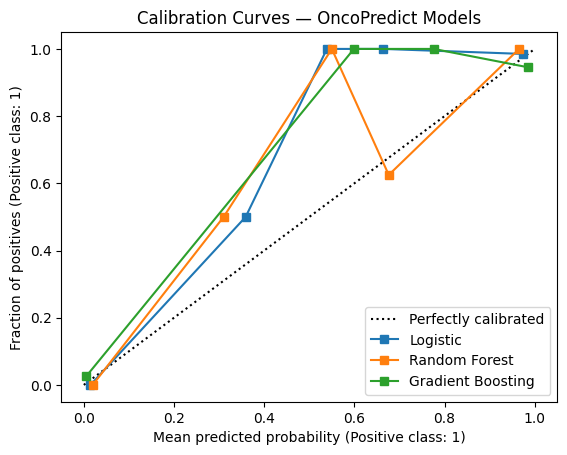

In [39]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots()

CalibrationDisplay.from_predictions(y_test, y_proba_lr, name="Logistic", ax=ax)
CalibrationDisplay.from_predictions(y_test, y_proba_rf, name="Random Forest", ax=ax)
CalibrationDisplay.from_predictions(y_test, y_proba_gb, name="Gradient Boosting", ax=ax)

ax.set_title("Calibration Curves — OncoPredict Models")
plt.show()


In [26]:
import shap


In [27]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


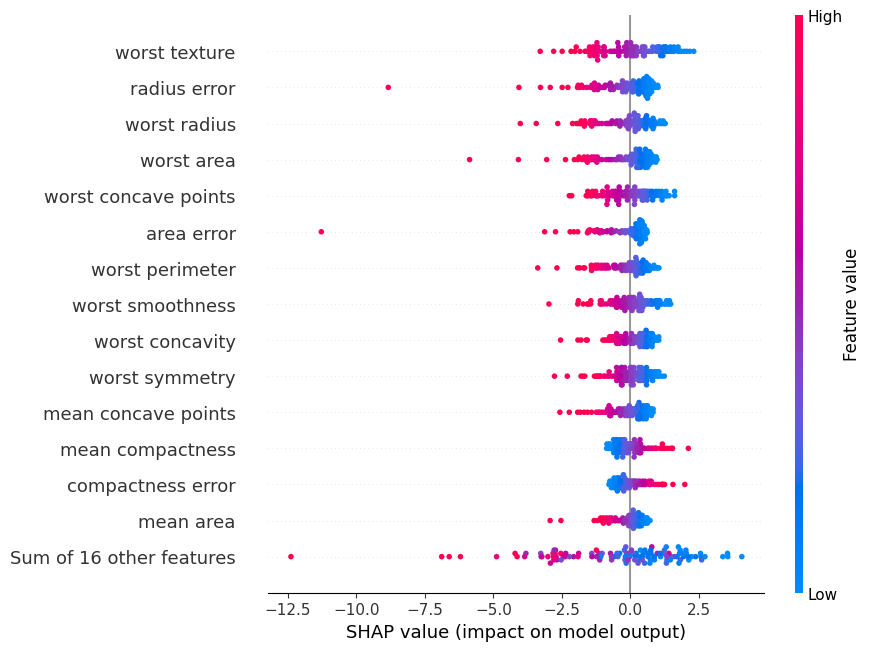

In [29]:
import shap
import numpy as np

# Get transformed feature matrix (scaled)
X_train_scaled = log_model.named_steps["scaler"].transform(X_train)
X_test_scaled = log_model.named_steps["scaler"].transform(X_test)

lr_clf = log_model.named_steps["model"]

explainer_lr = shap.LinearExplainer(lr_clf, X_train_scaled, feature_names=X.columns)
shap_values_lr = explainer_lr(X_test_scaled)

shap.plots.beeswarm(shap_values_lr, max_display=15)


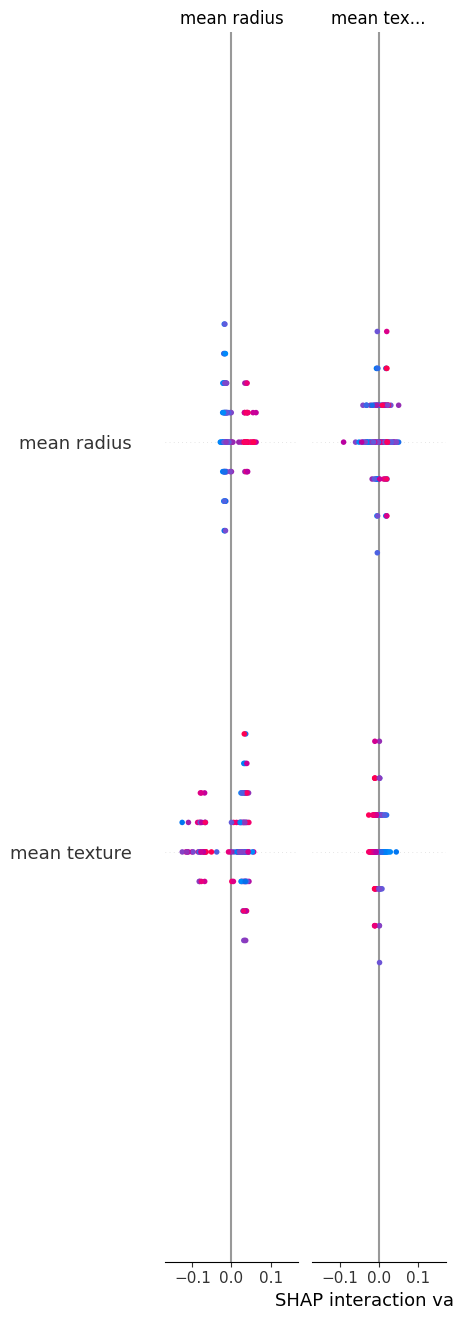

In [33]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# For binary classification, shap sometimes returns list [class0, class1]
# We'll try to use class 1 (benign) if list, otherwise use as-is.
vals = shap_values_rf[1] if isinstance(shap_values_rf, list) else shap_values_rf

shap.summary_plot(vals, X_test, feature_names=X.columns, max_display=15)


In [40]:
from sklearn.metrics import brier_score_loss

print("Brier Scores (lower = better):")
print("Logistic:", brier_score_loss(y_test, y_proba_lr))
print("Random Forest:", brier_score_loss(y_test, y_proba_rf))
print("Gradient Boosting:", brier_score_loss(y_test, y_proba_gb))


Brier Scores (lower = better):
Logistic: 0.02154127744404238
Random Forest: 0.032959429824561404
Gradient Boosting: 0.03959127835971863


In [41]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def calibration_slope_intercept(y_true, y_prob):
    y_prob = np.clip(y_prob, 1e-6, 1-1e-6)
    logit_p = np.log(y_prob/(1-y_prob))
    
    lr = LogisticRegression()
    lr.fit(logit_p.reshape(-1,1), y_true)
    
    return lr.coef_[0][0], lr.intercept_[0]

print("\nCalibration Slope / Intercept:")
for name, probs in [
    ("Logistic", y_proba_lr),
    ("Random Forest", y_proba_rf),
    ("Gradient Boosting", y_proba_gb)
]:
    slope, intercept = calibration_slope_intercept(y_test, probs)
    print(f"{name}: slope={slope:.3f}, intercept={intercept:.3f}")



Calibration Slope / Intercept:
Logistic: slope=1.154, intercept=0.719
Random Forest: slope=1.317, intercept=0.467
Gradient Boosting: slope=0.660, intercept=-0.113


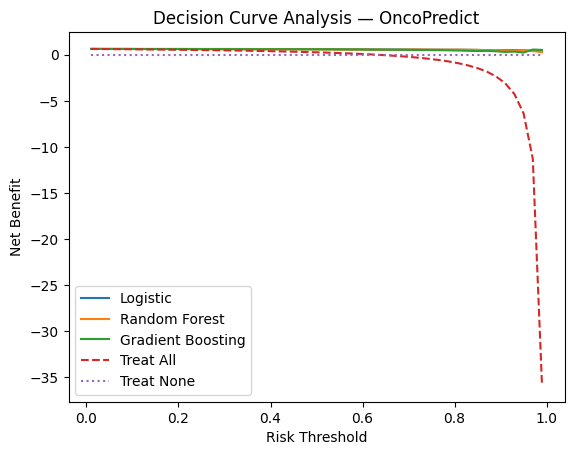

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def decision_curve(y_true, y_prob, thresholds):
    net_benefit = []
    N = len(y_true)
    
    for t in thresholds:
        preds = y_prob >= t
        
        TP = np.sum((preds == 1) & (y_true == 1))
        FP = np.sum((preds == 1) & (y_true == 0))
        
        nb = (TP/N) - (FP/N)*(t/(1-t))
        net_benefit.append(nb)
        
    return net_benefit

thresholds = np.linspace(0.01, 0.99, 50)

plt.figure()

for name, probs in [
    ("Logistic", y_proba_lr),
    ("Random Forest", y_proba_rf),
    ("Gradient Boosting", y_proba_gb)
]:
    nb = decision_curve(y_test.values, probs, thresholds)
    plt.plot(thresholds, nb, label=name)

# Treat all baseline
prevalence = np.mean(y_test)
treat_all = prevalence - (1-prevalence)*(thresholds/(1-thresholds))
plt.plot(thresholds, treat_all, linestyle="--", label="Treat All")

# Treat none baseline
plt.plot(thresholds, np.zeros_like(thresholds), linestyle=":", label="Treat None")

plt.xlabel("Risk Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis — OncoPredict")
plt.legend()
plt.show()


In [44]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    brier_score_loss
)

# --- Helper: calibration slope/intercept ---
from sklearn.linear_model import LogisticRegression
import numpy as np

def calibration_slope_intercept(y_true, y_prob):
    y_prob = np.clip(y_prob, 1e-6, 1 - 1e-6)
    logit_p = np.log(y_prob / (1 - y_prob))

    lr = LogisticRegression()
    lr.fit(logit_p.reshape(-1, 1), y_true)

    return lr.coef_[0][0], lr.intercept_[0]


# --- Predictions (already created earlier, but safe if rerun) ---
y_pred_lr = (y_proba_lr >= BEST_THRESHOLD).astype(int)
y_pred_rf = y_pred_rf
y_pred_gb = y_pred_gb


# --- Build Comparison Table ---
rows = []

for name, y_pred, y_prob in [
    ("Logistic Regression", y_pred_lr, y_proba_lr),
    ("Random Forest", y_pred_rf, y_proba_rf),
    ("Gradient Boosting", y_pred_gb, y_proba_gb),
]:
    
    slope, intercept = calibration_slope_intercept(y_test, y_prob)

    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob),
        "Brier Score": brier_score_loss(y_test, y_prob),
        "Calib Slope": slope,
        "Calib Intercept": intercept
    })


comparison_df = pd.DataFrame(rows).set_index("Model")
comparison_df.sort_values("ROC AUC", ascending=False)


,Accuracy,Precision,Recall,F1,ROC AUC,Brier Score,Calib Slope,Calib Intercept
Model,,,,,,,,
Logistic Regression,0.982456,0.986111,0.986111,0.986111,0.995370,0.021541,1.153795,0.718538
Random Forest,0.956140,0.958904,0.972222,0.965517,0.993056,0.032959,1.317234,0.466878
Gradient Boosting,0.956140,0.946667,0.986111,0.965986,0.991071,0.039591,0.659797,-0.113134


In [45]:
comparison_df.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1": "{:.3f}",
    "ROC AUC": "{:.4f}",
    "Brier Score": "{:.4f}",
    "Calib Slope": "{:.3f}",
    "Calib Intercept": "{:.3f}"
})

,Accuracy,Precision,Recall,F1,ROC AUC,Brier Score,Calib Slope,Calib Intercept
Model,,,,,,,,
Logistic Regression,0.982,0.986,0.986,0.986,0.9954,0.0215,1.154,0.719
Random Forest,0.956,0.959,0.972,0.966,0.9931,0.0330,1.317,0.467
Gradient Boosting,0.956,0.947,0.986,0.966,0.9911,0.0396,0.660,-0.113


In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss, accuracy_score, precision_score, recall_score, f1_score

def bootstrap_ci_binary(y_true, y_prob, threshold=0.5, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    n = len(y_true)
    stats = []

    for _ in range(n_boot):
        idx = rng.integers(0, n, n)  # resample with replacement
        yt = y_true[idx]
        yp = y_prob[idx]
        yhat = (yp >= threshold).astype(int)

        # Some bootstrap resamples can be all-one-class -> AUC undefined; skip those
        if len(np.unique(yt)) < 2:
            continue

        stats.append({
            "AUC": roc_auc_score(yt, yp),
            "Brier": brier_score_loss(yt, yp),
            "Accuracy": accuracy_score(yt, yhat),
            "Precision": precision_score(yt, yhat, zero_division=0),
            "Recall": recall_score(yt, yhat, zero_division=0),
            "F1": f1_score(yt, yhat, zero_division=0),
        })

    df = pd.DataFrame(stats)

    def ci(col):
        return (df[col].mean(),
                np.quantile(df[col], 0.025),
                np.quantile(df[col], 0.975))

    summary = pd.DataFrame({
        "metric": ["AUC","Brier","Accuracy","Precision","Recall","F1"],
        "mean":   [ci("AUC")[0], ci("Brier")[0], ci("Accuracy")[0], ci("Precision")[0], ci("Recall")[0], ci("F1")[0]],
        "ci_low": [ci("AUC")[1], ci("Brier")[1], ci("Accuracy")[1], ci("Precision")[1], ci("Recall")[1], ci("F1")[1]],
        "ci_high":[ci("AUC")[2], ci("Brier")[2], ci("Accuracy")[2], ci("Precision")[2], ci("Recall")[2], ci("F1")[2]],
    })
    return summary

# Use your chosen threshold for LR (BEST_THRESHOLD) and 0.5 for tree models (or tune them too)
ci_lr = bootstrap_ci_binary(y_test, y_proba_lr, threshold=BEST_THRESHOLD, n_boot=2000)
ci_rf = bootstrap_ci_binary(y_test, y_proba_rf, threshold=0.5, n_boot=2000)
ci_gb = bootstrap_ci_binary(y_test, y_proba_gb, threshold=0.5, n_boot=2000)

ci_lr["model"] = "Logistic"
ci_rf["model"] = "Random Forest"
ci_gb["model"] = "Gradient Boosting"

ci_all = pd.concat([ci_lr, ci_rf, ci_gb], ignore_index=True)
ci_all = ci_all[["model","metric","mean","ci_low","ci_high"]]
ci_all


,model,metric,mean,ci_low,ci_high
0,Logistic,AUC,0.995462,0.983442,1.000000
1,Logistic,Brier,0.021218,0.007064,0.040177
2,Logistic,Accuracy,0.982982,0.956140,1.000000
3,Logistic,Precision,0.986513,0.955224,1.000000
4,Logistic,Recall,0.986568,0.955224,1.000000
5,Logistic,F1,0.986446,0.964539,1.000000
6,Random Forest,AUC,0.993070,0.980880,0.999666
7,Random Forest,Brier,0.032873,0.016486,0.053431
8,Random Forest,Accuracy,0.956390,0.912281,0.991228
9,Random Forest,Precision,0.959640,0.907692,1.000000


In [69]:
ci_all.style.format({"mean":"{:.4f}","ci_low":"{:.4f}","ci_high":"{:.4f}"})


,model,metric,mean,ci_low,ci_high
0,Logistic,AUC,0.9955,0.9834,1.0000
1,Logistic,Brier,0.0212,0.0071,0.0402
2,Logistic,Accuracy,0.9830,0.9561,1.0000
3,Logistic,Precision,0.9865,0.9552,1.0000
4,Logistic,Recall,0.9866,0.9552,1.0000
5,Logistic,F1,0.9864,0.9645,1.0000
6,Random Forest,AUC,0.9931,0.9809,0.9997
7,Random Forest,Brier,0.0329,0.0165,0.0534
8,Random Forest,Accuracy,0.9564,0.9123,0.9912
9,Random Forest,Precision,0.9596,0.9077,1.0000


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone

def evaluate_on_split(model, Xtr, ytr, Xte, yte, threshold=0.5):
    m = clone(model)
    m.fit(Xtr, ytr)
    prob = m.predict_proba(Xte)[:, 1]
    pred = (prob >= threshold).astype(int)
    return {
        "AUC": roc_auc_score(yte, prob),
        "Brier": brier_score_loss(yte, prob),
        "Recall": recall_score(yte, pred, zero_division=0),
        "Precision": precision_score(yte, pred, zero_division=0),
        "F1": f1_score(yte, pred, zero_division=0),
        "Accuracy": accuracy_score(yte, pred),
    }

sss = StratifiedShuffleSplit(n_splits=200, test_size=0.2, random_state=42)

records = []
for i, (tr_idx, te_idx) in enumerate(sss.split(X, y)):
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]

    records.append({"model":"Logistic", **evaluate_on_split(log_reg_pipeline, Xtr, ytr, Xte, yte, threshold=BEST_THRESHOLD)})
    records.append({"model":"Random Forest", **evaluate_on_split(rf, Xtr, ytr, Xte, yte, threshold=0.5)})
    records.append({"model":"Gradient Boosting", **evaluate_on_split(gb, Xtr, ytr, Xte, yte, threshold=0.5)})

dist_df = pd.DataFrame(records)
dist_df.groupby("model")[["AUC","Brier","Recall","Precision","F1","Accuracy"]].agg(["mean","std","min","max"])


In [70]:
import numpy as np

def make_shifted(X_in, noise_std=0.15, scale_std=0.10, seed=0):
    rng = np.random.default_rng(seed)
    Xn = X_in.copy()
    # multiplicative scale shift per feature
    scales = rng.normal(1.0, scale_std, size=Xn.shape[1])
    # additive noise proportional to feature std
    feat_std = Xn.std(axis=0).values
    noise = rng.normal(0.0, noise_std, size=Xn.shape) * feat_std
    Xn = Xn * scales + noise
    return Xn

X_shift = make_shifted(X_test, noise_std=0.20, scale_std=0.15, seed=42)

def eval_probs(y_true, y_prob, thr=0.5):
    pred = (y_prob >= thr).astype(int)
    return {
        "AUC": roc_auc_score(y_true, y_prob),
        "Brier": brier_score_loss(y_true, y_prob),
        "Recall": recall_score(y_true, pred, zero_division=0),
        "Accuracy": accuracy_score(y_true, pred),
    }

# Train on original train, test on shifted
log_reg_pipeline.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

p_lr = log_reg_pipeline.predict_proba(X_shift)[:,1]
p_rf = rf.predict_proba(X_shift)[:,1]
p_gb = gb.predict_proba(X_shift)[:,1]

pd.DataFrame([
    {"model":"Logistic", **eval_probs(y_test, p_lr, thr=BEST_THRESHOLD)},
    {"model":"Random Forest", **eval_probs(y_test, p_rf, thr=0.5)},
    {"model":"Gradient Boosting", **eval_probs(y_test, p_gb, thr=0.5)},
])


,model,AUC,Brier,Recall,Accuracy
0,Logistic,0.995370,0.020174,1.000000,0.991228
1,Random Forest,0.988426,0.053016,0.916667,0.921053
2,Gradient Boosting,0.989418,0.035557,0.986111,0.964912


In [71]:
import numpy as np

def make_shifted(X_in, noise_std=0.15, scale_std=0.10, seed=0):
    rng = np.random.default_rng(seed)
    Xn = X_in.copy()
    # multiplicative scale shift per feature
    scales = rng.normal(1.0, scale_std, size=Xn.shape[1])
    # additive noise proportional to feature std
    feat_std = Xn.std(axis=0).values
    noise = rng.normal(0.0, noise_std, size=Xn.shape) * feat_std
    Xn = Xn * scales + noise
    return Xn

X_shift = make_shifted(X_test, noise_std=0.20, scale_std=0.15, seed=42)

def eval_probs(y_true, y_prob, thr=0.5):
    pred = (y_prob >= thr).astype(int)
    return {
        "AUC": roc_auc_score(y_true, y_prob),
        "Brier": brier_score_loss(y_true, y_prob),
        "Recall": recall_score(y_true, pred, zero_division=0),
        "Accuracy": accuracy_score(y_true, pred),
    }

# Train on original train, test on shifted
log_reg_pipeline.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

p_lr = log_reg_pipeline.predict_proba(X_shift)[:,1]
p_rf = rf.predict_proba(X_shift)[:,1]
p_gb = gb.predict_proba(X_shift)[:,1]

pd.DataFrame([
    {"model":"Logistic", **eval_probs(y_test, p_lr, thr=BEST_THRESHOLD)},
    {"model":"Random Forest", **eval_probs(y_test, p_rf, thr=0.5)},
    {"model":"Gradient Boosting", **eval_probs(y_test, p_gb, thr=0.5)},
])


,model,AUC,Brier,Recall,Accuracy
0,Logistic,0.995370,0.020174,1.000000,0.991228
1,Random Forest,0.988426,0.053016,0.916667,0.921053
2,Gradient Boosting,0.989418,0.035557,0.986111,0.964912


In [74]:
from sklearn.base import clone
import numpy as np
import pandas as pd

def bootstrap_predictive_distribution(model, Xtr, ytr, X_eval, n_boot=300, seed=42):
    rng = np.random.default_rng(seed)
    probs = []

    Xtr_np = Xtr.copy()
    ytr_np = ytr.copy()

    for b in range(n_boot):
        idx = rng.integers(0, len(ytr_np), len(ytr_np))
        m = clone(model)

        if hasattr(Xtr_np, "iloc"):
            Xb = Xtr_np.iloc[idx]
            yb = ytr_np.iloc[idx]
        else:
            Xb = Xtr_np[idx]
            yb = ytr_np[idx]

        m.fit(Xb, yb)
        probs.append(m.predict_proba(X_eval)[:, 1])

    probs = np.vstack(probs)
    return probs

probs_lr_boot = bootstrap_predictive_distribution(
    log_reg_pipeline,
    X_train,
    y_train,
    X_test,
    n_boot=300
)

summary_lr = pd.DataFrame({
    "p_mean": probs_lr_boot.mean(axis=0),
    "p_p05": np.quantile(probs_lr_boot, 0.05, axis=0),
    "p_p95": np.quantile(probs_lr_boot, 0.95, axis=0),
})

summary_lr.head(10)


,p_mean,p_p05,p_p95
0,1.010457e-07,2.724966e-09,3.572729e-07
1,9.999876e-01,9.999637e-01,9.999988e-01
2,7.851983e-03,1.820339e-03,1.955492e-02
3,5.500895e-01,3.299016e-01,7.636299e-01
4,1.802574e-09,2.473257e-11,1.086495e-08
5,9.926133e-01,9.857075e-01,9.976214e-01
6,9.999644e-01,9.998272e-01,9.999995e-01
7,7.587037e-07,4.926119e-08,2.331927e-06
8,6.116183e-05,1.095314e-05,1.888181e-04
9,2.253515e-10,8.082411e-13,9.692624e-10


In [75]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.base import clone

# Split train into (proper train) + (calibration set)
X_tr2, X_cal, y_tr2, y_cal = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

m = clone(log_reg_pipeline)
m.fit(X_tr2, y_tr2)

# Nonconformity score: 1 - prob(true_label)
proba_cal = m.predict_proba(X_cal)
scores = 1 - proba_cal[np.arange(len(y_cal)), y_cal.values]

alpha = 0.10  # 90% coverage
qhat = np.quantile(scores, 1 - alpha)

proba_test = m.predict_proba(X_test)

# Prediction set: include class k if 1 - p_k <= qhat  => p_k >= 1 - qhat
threshold_set = 1 - qhat
pred_sets = (proba_test >= threshold_set)

# How often does the true label fall in the set?
covered = pred_sets[np.arange(len(y_test)), y_test.values]
coverage = covered.mean()

avg_set_size = pred_sets.sum(axis=1).mean()

coverage, avg_set_size, threshold_set


(np.float64(0.868421052631579),
 np.float64(0.8771929824561403),
 np.float64(0.8644142347507304))

In [76]:
print("\nConformal Prediction Summary:")
print(f"Coverage (target ~90%): {coverage:.3f}")
print(f"Average prediction set size: {avg_set_size:.3f}")
print(f"Probability inclusion threshold: {threshold_set:.3f}")



Conformal Prediction Summary:
Coverage (target ~90%): 0.868
Average prediction set size: 0.877
Probability inclusion threshold: 0.864


In [77]:
conformal_summary = pd.DataFrame({
    "Metric": [
        "Conformal Coverage",
        "Avg Prediction Set Size",
        "Prediction Inclusion Threshold"
    ],
    "Value": [
        coverage,
        avg_set_size,
        threshold_set
    ]
})

display(conformal_summary)


,Metric,Value
0,Conformal Coverage,0.868421
1,Avg Prediction Set Size,0.877193
2,Prediction Inclusion Threshold,0.864414


In [78]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss, confusion_matrix

def calibration_slope_intercept(y_true, y_prob):
    y_prob = np.clip(y_prob, 1e-6, 1 - 1e-6)
    logit_p = np.log(y_prob / (1 - y_prob))
    
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression()
    lr.fit(logit_p.reshape(-1, 1), y_true)
    
    return lr.coef_[0][0], lr.intercept_[0]

def get_fn_fp(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    FN = cm[0, 1]
    FP = cm[1, 0]
    return FN, FP

rows = []

models = [
    ("Logistic", y_pred_lr, y_proba_lr),
    ("Random Forest", y_pred_rf, y_proba_rf),
    ("Gradient Boosting", y_pred_gb, y_proba_gb),
]

for name, y_pred, y_prob in models:
    
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_prob)
    slope, intercept = calibration_slope_intercept(y_test, y_prob)
    FN, FP = get_fn_fp(y_test, y_pred)
    
    rows.append([
        name,
        auc,
        acc,
        brier,
        slope,
        intercept,
        FN,
        FP
    ])

comparison_table = pd.DataFrame(rows, columns=[
    "Model",
    "ROC_AUC",
    "Accuracy",
    "Brier Score ↓",
    "Calibration Slope",
    "Calibration Intercept",
    "False Negatives ↓",
    "False Positives ↓"
])

comparison_table = comparison_table.sort_values("ROC_AUC", ascending=False)

display(comparison_table)


,Model,ROC_AUC,Accuracy,Brier Score ↓,Calibration Slope,Calibration Intercept,False Negatives ↓,False Positives ↓
0,Logistic,0.995370,0.982456,0.021541,1.153795,0.718538,1,1
1,Random Forest,0.993056,0.956140,0.032959,1.317234,0.466878,3,2
2,Gradient Boosting,0.991071,0.956140,0.039591,0.659797,-0.113134,4,1


In [79]:
comparison_table_rounded = comparison_table.copy()

for col in [
    "ROC_AUC",
    "Accuracy",
    "Brier Score ↓",
    "Calibration Slope",
    "Calibration Intercept"
]:
    comparison_table_rounded[col] = comparison_table_rounded[col].astype(float).round(3)

display(comparison_table_rounded)


,Model,ROC_AUC,Accuracy,Brier Score ↓,Calibration Slope,Calibration Intercept,False Negatives ↓,False Positives ↓
0,Logistic,0.995,0.982,0.022,1.154,0.719,1,1
1,Random Forest,0.993,0.956,0.033,1.317,0.467,3,2
2,Gradient Boosting,0.991,0.956,0.040,0.660,-0.113,4,1
